In [1]:
import torch
from torch import nn
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=UserWarning)
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor
from rdkit import Chem

"""
    load data
"""
dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 6000, False))

V = 9
atom_types = [6, 8, 7, 9, 1]

def adj(x):
    x = x[1]
    adjacency = np.zeros((V, V)).astype(float)
    adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
    return torch.tensor(adjacency)


def sig(x):
    x = x[0]
    atoms = np.ones((V)).astype(float)
    atoms[:len(x)] = x
    out = np.array([int(atom == atom_type) for atom_type in atom_types for atom in atoms]).astype(float)
    return torch.tensor(out).reshape(5, len(atoms)).T


def target(x):
    x = x[2]
    return torch.tensor(x)

def target_2(smiles):
    """
        compute the number of hydrogen-bond acceptor atoms
    :param smiles: smiles molecular representation
    :return:
    """
    mol = Chem.MolFromSmiles(smiles)

    return torch.tensor(Chem.rdMolDescriptors.CalcNumHBA(mol))


adjs = torch.stack(list(map(adj, dataset)))
sigs = torch.stack(list(map(sig, dataset)))
prop = torch.stack(list(map(target, dataset)))[:, 5]
prop_2 = torch.stack(list(map(target_2, dataset_smiles)))


class PoolingLayer:
    """
        Graph pooling layer
    """
    def __init__(self, TypePooling):
        self.TypePooling = TypePooling
        # pass

    def __call__(self, H):
        # -- multi-set pooling operator

        if self.TypePooling == "Sum":
            Pool = H.sum(dim=1)

        elif self.TypePooling == "Max":
            Pool = H.max(dim=1)[0]

        elif self.TypePooling == "Mean":
            Pool = H.mean(dim=1)

        return Pool

100%|██████████| 6000/6000 [00:03<00:00, 1715.09it/s]


In [3]:
def Get_Ds_hat(adj_matrix):

    # Get degree of adjency matrix
    D_hat = np.diag(np.power(np.array(adj_matrix.sum(1) + 1e-5), -0.5).flatten())
    
    # Return D^0.5 
    return torch.tensor(D_hat)

def Get_Identity(adj_matrix):

    m,n = adj_matrix.shape

    identity = np.eye(n).astype(float)

    return torch.tensor(identity)

def Get_Auxiliar(adj_matrix):

    m,n = adj_matrix.shape

    auxiliar = np.ones((n,n))

    return torch.tensor(auxiliar)

In [4]:
Ds_tensor  = torch.stack(list(map(Get_Ds_hat, adjs)))
Is_tensor  = torch.stack(list(map(Get_Identity, adjs)))
# Aux_Tensor = torch.stack(list(map(Get_Auxiliar, adjs)))

Laplacian  = Is_tensor - Ds_tensor@adjs@Ds_tensor # + Aux_Tensor*1e-3

In [5]:
def Get_EigVector(laplacian):

    eigenvalues, eigenvector = np.linalg.eigh(laplacian)

    for i in range(len(eigenvalues)):
        if i == 0:
            eigenvector_matrix = eigenvector[:,i]
        else:
            eigenvector_matrix = np.vstack((eigenvector_matrix, eigenvector[:,i]))

    return torch.tensor(eigenvector_matrix)

def Get_EigValues(laplacian):

    eigenvalues, eigenvector = np.linalg.eigh(laplacian)

    return torch.tensor(eigenvalues)

In [6]:
EigenVector_Tensor = torch.stack(list(map(Get_EigVector, Laplacian)))
EigenValuesTensor  = torch.stack(list(map(Get_EigValues, Laplacian)))

EigenVector_Tensor_T = torch.transpose(EigenVector_Tensor, 1, 2)


In [7]:
PoolingMean = PoolingLayer("Mean")

filtratedsig_Layer_0_cat = PoolingMean(sigs)

from Utils import g_hat_j

Kappa = 1
d0 = d1 = 0.5
R = 3
J = 8
lambda_max = 2

# Dilation Factor
a = R*np.log(lambda_max)/(J-R+1)

In [8]:
def filter_signal(eigvalue_matrix):
    
    n, = eigvalue_matrix.shape
    filtered_matrix = np.zeros((n, n))

    # print(index_filter)

    for iu in range(n):
        filtered_matrix[iu,iu] = g_hat_j(eigvalue_matrix[iu], a, index_filter, R, [d0, d1], J, Kappa)

    return torch.tensor(filtered_matrix)

In [10]:
# Kappa = 1
# d0 = d1 = 0.5
# R = 3
# J = 8
# lambda_max = 2

# # Dilation Factor
# a = R*np.log(lambda_max)/(J-R+1)

TotalFilters = 8

it_internal = 0

for cu_Filter in range(1, TotalFilters+1):
    index_filter = cu_Filter # from 1 to 8

    g_eig_1 = torch.stack(list(map(filter_signal, EigenValuesTensor)))

    conv_values_1 = torch.abs(EigenVector_Tensor @ g_eig_1 @ EigenVector_Tensor_T @ sigs)
    filtratedsig_Layer_1 = PoolingMean(conv_values_1)

    if cu_Filter == 1:
        filtratedsig_Layer_1_cat = filtratedsig_Layer_1
    else:
        filtratedsig_Layer_1_cat = torch.cat((filtratedsig_Layer_1_cat, filtratedsig_Layer_1), dim = 1)

    for int_filter in range(1, TotalFilters+1):
        index_filter = int_filter

        g_eig_2 = torch.stack(list(map(filter_signal, EigenValuesTensor)))
        conv_values_2 = torch.abs(EigenVector_Tensor @ g_eig_2 @ EigenVector_Tensor_T @ conv_values_1)
        filtratedsig_Layer_2 = PoolingMean(conv_values_2)

        if it_internal == 0:
            filtratedsig_Layer_2_cat = filtratedsig_Layer_2
        else:
            filtratedsig_Layer_2_cat = torch.cat((filtratedsig_Layer_2_cat, filtratedsig_Layer_2), dim = 1)

        it_internal += 1



In [11]:
print(filtratedsig_Layer_1_cat.shape) 

print(filtratedsig_Layer_2_cat.shape)

torch.Size([6000, 40])
torch.Size([6000, 320])


In [12]:
Z_G_lat_space = torch.cat((filtratedsig_Layer_0_cat, filtratedsig_Layer_1_cat, filtratedsig_Layer_2_cat), dim = 1)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_fit = pca.fit(Z_G_lat_space).transform(Z_G_lat_space)

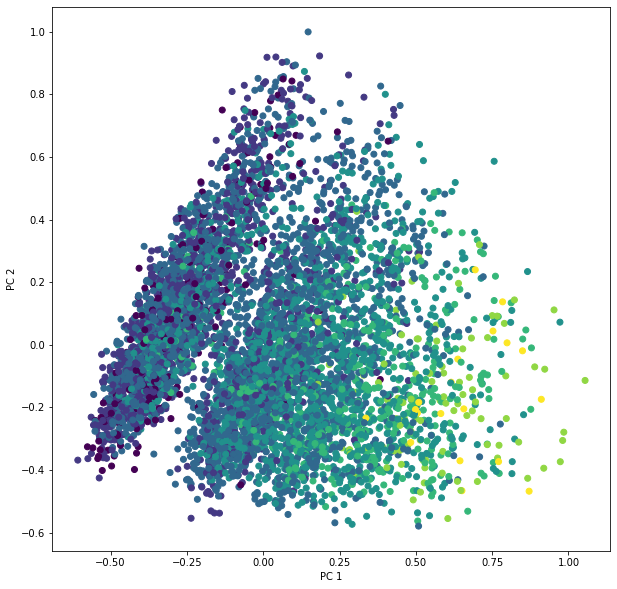

In [56]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
plt.scatter(X_fit[:,0], X_fit[:,1], c = prop_2)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [98]:
nGraph, in_dim = Z_G_lat_space.shape
out_dim = in_dim*2

In [99]:
Z_G_lat_space_dtype = torch.tensor(Z_G_lat_space, dtype=torch.float)

In [100]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_dim, out_dim//2, bias = True)  # 5*5 from image dimension
        self.fc2 = nn.Linear(out_dim//2, out_dim//8, bias = True)
        self.fc3 = nn.Linear(out_dim//8, 1, bias = True)

        # self.fc2 = nn.Linear(out_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.fc2(x)
        
        return x


net = Net(in_dim, out_dim)
print(net)

Net(
  (fc1): Linear(in_features=365, out_features=365, bias=True)
  (fc2): Linear(in_features=365, out_features=91, bias=True)
  (fc3): Linear(in_features=91, out_features=1, bias=True)
)


In [101]:
import torch.optim as optim


model = Net(in_dim, out_dim)

MyLoss      = nn.MSELoss()
MyOptimizer = optim.SGD(model.parameters(), lr=1e-2)


Z_G_lat_space_train = Z_G_lat_space_dtype[0:5000]
Z_G_lat_space_test  = Z_G_lat_space_dtype[5000:]

prop_train = prop[0:5000]
prop_test  = prop[5000:]

loss_epoch  = []
batch_size = 100
# -- update parameters
for epoch in range(200):
    
    cum_loss = 0
    
    # 50 iterations needed for 5000 samples
    
    for i in range(50):

        # -- predict
        MyOptimizer.zero_grad()
        pred = model(Z_G_lat_space_train[i*batch_size:(i+1)*batch_size])
        labels = prop_train[i*batch_size:(i+1)*batch_size]

        # -- loss
        loss = MyLoss(pred,labels)
        
        # -- optimize
        loss.backward()
        MyOptimizer.step()
        
        cum_loss += loss.item()
    
    loss_epoch.append(cum_loss/50)


    # MyOptimizer.zero_grad()
    # pred = model(Z_G_lat_space_train)
    # labels = prop_train

    #     # -- loss
    # loss = MyLoss(pred,labels)
        
    #     # -- optimize
    # loss.backward()
    # MyOptimizer.step()
        
    # cum_loss = loss.item()
    
    # loss_epoch.append(cum_loss)
    #print(f'Loss: {cum_loss/10}')


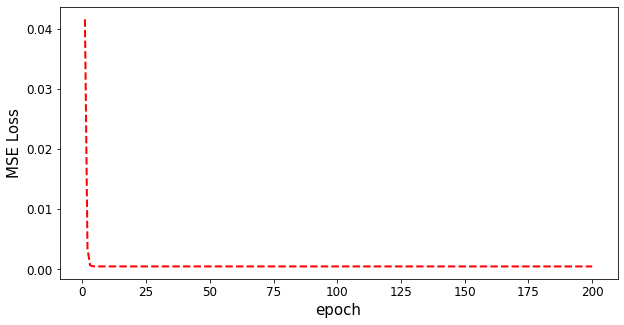

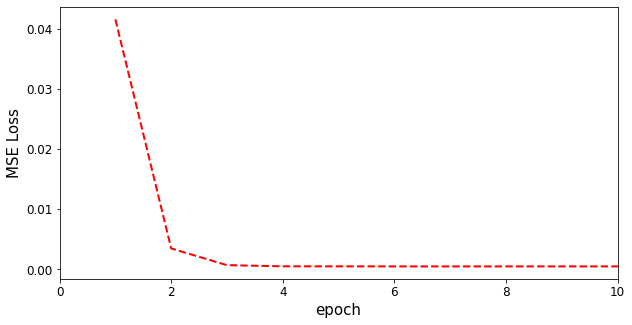

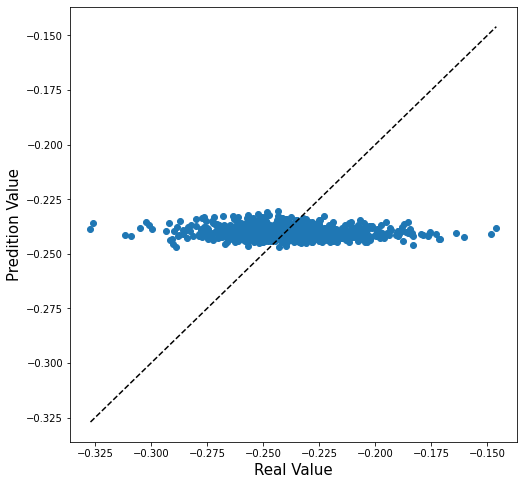

In [103]:
# -- plot loss
X = np.arange(1,201)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, loss_epoch,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)
plt.show()

# -- plot loss
X = np.arange(1,201)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, loss_epoch,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)
plt.xlim([0,10])
plt.show()

pred = model(Z_G_lat_space_test)
labels = prop_test

pred = pred.detach().numpy()
labels = labels.detach().numpy()

fig = plt.figure(figsize=(8,8))
plt.scatter(labels, pred, alpha=1.0)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], "--k")
plt.xlabel('Real Value', fontsize=15)
plt.ylabel('Predition Value', fontsize=15)
plt.show()